In [329]:
import os
import random
import pickle
#import wget 
from urllib.request import urlretrieve
from  urllib.request import urlopen
import urllib.error 
import numpy as np
import tensorflow as tf
import math
import matplotlib.pyplot as plt
import cv2
import imgaug as ia
from imgaug import augmenters as iaa
from enum import Enum, unique
import inspect
from PIL import Image
from tqdm import tqdm
from zipfile import ZipFile
from tensorflow.python.ops.variables import Variable
from functools import partial
from itertools import groupby
import pycuda
import pycuda.driver as cuda
%matplotlib inline

print('All modules imported.')

source = 'https://d17h27t6h515a5.cloudfront.net/topher/2016/November/581faac4_traffic-signs-data/traffic-signs-data.zip'
repository = 'traffic-signs-data.zip'
batch_count = 128
rate = 0.001
EPOCHS = 10
BATCH_SIZE = 128

All modules imported.


In [330]:


class Dataset(object):
    def __init__(self,source, repository):
        
        print('Status of Initialization Step #0')
        if source is None:
            print('None source parameter is not allowed. Please, provide a source parameter.')
            return None
        if len(source)==0:
            print("Empty source parameter is not allowed. Please, provide a valid source parameter.")
            return None
        if repository is None:
            print('None repository parameter is not allowed. Please, provide a repository parameter.')
            return None
        if len(repository)==0:
            print("Empty repository parameter is not allowed. Please, provide a valid repository parameter.")
            return None
        
        
        self.__source = source
        self.__repository=repository
        self.__datacached,self.__dataloaded = False,False
        self.__downloaded , self.__uncompressed = 0,0
        self.train_size, self.test_size,self.class_size,self.label_per_class = 0,0,0,[]
        self.image_shape = None
        self.max_size_feature = [0,0]
        
    def __wget(self, source, repository):
        try:
            print(source)
            content = urlopen(source)
            repository = open(source.split('/')[-1], 'w')
            repository.write(content.read())
            content.close()
            repository.close()
        except Exception as err:
            print('ERROR:', str(err))
            raise 
        
    
    def __download(self):
        print('Download Step #1')
        #print(self.__source)
        for src, rep in tqdm(zip(self.__source, self.__repository)):
            try :
                if not os.path.isfile(rep):
                    print('Start download files from '+src+'...')
                    urlretrieve(src,rep)
                    #rep = wget.download(src)
                    #self.__wget(src,rep)
                    print('Download finished.')
                    self.__downloaded += 1
                else :
                    print('Repository path '+rep+ ' is file! We can not save\
                            files because no directory path is provided.')
            except urllib.error.URLError: #Exception as inst : #
                    print('file not found corresponding to ' + src +'. moving on...')
                    raise
                    
        if self.__downloaded != 0 :
            print('Status of download Step : ' +str(self.__downloaded) + ' files are downloaded over '+\
                      str(len(self.__source)))
            
    def __uncompress(self):
        print('Uncompression Step #3')
        destfiles=[]
        for path in self.__repository :
        #Instantiate zipfile class as zipf context
            #print(path)
            with ZipFile(path,'r') as zipf:
                #extracting file name list using progressbar
                pbfiles = zipf.namelist()
                for fname in tqdm(pbfiles, unit='files'):
                    #check whether  file name do not point to a directory. Thus do not process it 
                    if not fname.endswith('/'):
                        #unzip the image file using the file name
                        print('Unzip the image file '+fname)
                        #with zipf.open(fname) as file:
                        zipf.extract(fname)

                        # Now store the uncompressed data
                        #fdest = fname[:-3]  # remove the '.gz' from the filename
                        #print(fdest)
                        destfiles.append(fname)
                        
            print('Status of uncompression Step :  '+ str(self.__uncompressed)+ \
                      'files are uncompressed over' +str(len(pbfiles)))
        destfiles = sorted(destfiles,key=os.path.getsize, reverse=True)
        return np.array(destfiles) 
    
    def __load(self,pkfile):
        # Reload the data
        print('Data Loading Step #4')
        train_features,train_labels = None,None
        if os.path.isfile(pkfile):
            #print(pkfile)
            with open(pkfile, 'rb') as f:
              pickle_data = pickle.load(f)
              features = pickle_data['features']
              labels = pickle_data['labels']
              del pickle_data  # Free up memory
            print('Status of Data loading from pickle file Step : successful')
            self.__dataloaded = True
        else :
            print('Status of Data loading from pickle file Step : failed')
        return features,labels
    
    def deserialize(self):
        desfiles = []
        print('The dataset deserialization process is starting...')
        
        if self.__downloaded==0:
            self.__download()
            
        if self.__uncompressed == 0:
            desfiles = self.__uncompress()
            
        if len(desfiles)==2 :
            train_features, train_labels = self.__load(desfiles[0])
            test_features,test_labels = self.__load(desfiles[1])
            self.train_size = train_features.shape[0]
            self.test_size = test_features.shape[0]
            self.image_shape = (train_features.shape[1],train_features.shape[2],train_features.shape[3])
            self.class_size = np.unique(train_labels).size
            self.label_per_class = np.array([(k,len(list(v))) for k,v in groupby(train_labels)])
           
            for t in self.label_per_class:
                
                if(self.max_size_feature[1]<t[1]):
                    self.max_size_feature = t
            
            
        print('The dataset deserialization process is terminated...')
        
        return train_features,train_labels, test_features,test_labels
    
    def visualize(self, X_train, y_train) :
        index = random.randint(0, len(X_train))
        image = X_train[index].squeeze()

        plt.figure(figsize=(1,1))
        plt.imshow(image)
        print(y_train[index])
        
    def __max(self, X_train, y_train, augmenter):
        #Define the max(class,label/feature)
        
        for t in self.label_per_class:
            if(self.max_size_feature[1]<t[1]):
                self.max_size_feature = t
    
    def balance(self,X_train,y_train,augmenter,args):
        #for each (class,feature/label) different from max, 
        # augment(class, feature/label) by the amount of tuple = max(class,feature) - nb(class,feature)
        # Adjust(class, label)
        # Append(Augmented(class,feature), train_feature)
        #params = (1,1)
        #print((augmenter) (*params))
        augfeatures,auglabels =[],[]
        
        start=0
        for t in self.label_per_class:
            augfeatures.append(X_train[t[1]])
            auglabels.append(y_train[t[1]])
            if t[1]!=self.max_size_feature[1]:
                compensation = self.max_size_feature[1]-t[1]
                print(compensation)
                for i in range(compensation-1):
                    bf = X_train[start:start+t[1]]
                    bl = y_train[start:start+t[1]]
                    args = (bf,args[1])
                    ft = (augmenter)(*args)
                    augfeatures.append(ft)
                    auglabels.append(bl)
                    start += t[1]
                    
        return augfeatures,auglabels
                

In [331]:
'''
sources = [source]
repositories = [repository]

ds = Dataset(sources, repositories)
X_train, y_train,X_test, y_test = ds.deserialize()
print("Number of training examples =", ds.train_size)
print("Number of testing examples =", ds.test_size)
print("Image data shape =", ds.image_shape)
print("Number of classes =", ds.class_size)
#print("Number of label_per_class =", ds.label_per_class)
print("Max size of label_per_class =", ds.max_size_feature)

ds.visualize(X_train, y_train)
'''

'\nsources = [source]\nrepositories = [repository]\n\nds = Dataset(sources, repositories)\nX_train, y_train,X_test, y_test = ds.deserialize()\nprint("Number of training examples =", ds.train_size)\nprint("Number of testing examples =", ds.test_size)\nprint("Image data shape =", ds.image_shape)\nprint("Number of classes =", ds.class_size)\n#print("Number of label_per_class =", ds.label_per_class)\nprint("Max size of label_per_class =", ds.max_size_feature)\n\nds.visualize(X_train, y_train)\n'

In [332]:
'''
1: Data Augmentation
    This technique provides a way genrerate more data from the existing and thus makes cnn or dnn to be 
    trained on huge number of training dataset to reach better performance and accuracy.
'''

class DataAugmenter(object):
    '''
    This library class is a data augmenter pipeline manager using the Augmenters Module referenced at this url:
    https://github.com/aleju/imgaug
   '''
    class Tasks(object):
        def __str__(self):
            return str(self.value)
        
        FlipVertical = 'flip_vertical'
        FlipHorizontal = 'flip_horizontal'
        Crop = 'crop'
        GaussianBlur = 'gaussian_blur'
        AdditiveGaussianNoise = 'additive_gaussian_noise'
        Dropout = 'dropout'
        Add = 'add'
        Multiply = 'multiply'
        ContrastNormalization = 'contrast_normalization'
        Affine = 'affine'
        ElasticTransformation = 'elastic_transformation'
        
        
    def __init__(self):
        
        # random example images
        #images = np.random.randint(0, 255, (16, 128, 128, 3), dtype=np.uint8)

        # Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
        # e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
        self.st = lambda aug: iaa.Sometimes(0.5, aug)
        self.pipeline = []
        # Define our sequence of augmentation steps that will be applied to every image
        # All augmenters with per_channel=0.5 will sample one value _per image_
        # in 50% of all cases. In all other cases they will sample new values
        # _per channel_.
        self.tasks = []
    
    def flip_horizontal(self):
        # horizontally flip 50% of all images
        if not "iaa.Fliplr" in self.pipeline:
            self.pipeline.append(iaa.Fliplr(0.5))
            
    def flip_vertical(self):
        # vertically flip 50% of all images
        if not "iaa.Flipud"  in self.pipeline:
            self.pipeline.append(iaa.Flipud(0.5))
            
    def crop(self):
        # crop images by crop range of 0-10%  of their height/width
        if not "iaa.Crop" in self.pipeline:
            self.pipeline.append(self.st(iaa.Crop(percent=(0, 0.1))))
    
    def gaussian_blur(self):
        # blur images with a sigma range between 0 and 3.0
        if not "iaa.GaussianBlur" in self.pipeline:
            self.pipeline.append(self.st(iaa.GaussianBlur((0, 3.0))))
    
    def additive_gaussian_noise(self):
        # add gaussian noise to images
        if "iaa.AdditiveGaussianNoise" in self.pipeline:
            self.pipeline.append(self.st(iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.2), per_channel=0.5)))
    
    def dropout(self):
        # randomly remove up to 10% of the pixels  
        if not "iaa.Dropout" in self.pipeline:
            self.pipeline.append(self.st(iaa.Dropout((0.0, 0.1), per_channel=0.5)))
    
    def add(self):
        # change brightness of images (by -10 to 10 of original value)
        if not "iaa.Add" in self.pipeline:
            self.pipeline.append(self.st(iaa.Add((-10, 10), per_channel=0.5)))
    
    def multiply(self):
        # change brightness of images (50-150% of original value)
        if not "iaa.Multiply" in self.pipeline:
            self.pipeline.append(self.st(iaa.Multiply((0.5, 1.5), per_channel=0.5)))
        
    def contrast_normalization(self):
        # improve or worsen the contrast
        if not "iaa.ContrastNormalization" in self.pipeline:
            self.pipeline.append(self.st(iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5)))
    
    def affine(self):
        
        if not "iaa.Affine" in self.pipeline:
            self.pipeline.append(self.st(iaa.Affine(
                    scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
                    translate_px={"x": (-16, 16), "y": (-16, 16)}, # translate by -16 to +16 pixels (per axis)
                    rotate=(-45, 45), # rotate by -45 to +45 degrees
                    shear=(-16, 16), # shear by -16 to +16 degrees
                    order=ia.ALL, # use any of scikit-image's interpolation methods
                    cval=(0, 1.0), # if mode is constant, use a cval between 0 and 1.0
                    mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
                )))
            
    def elastic_transformation(self):
        # apply elastic transformations with random strengths
        if not "iaa.ElasticTransformation" in self.pipeline:
            self.pipeline.append(self.st(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)))
    
        
    def register(self,tasks):
        #Allow to register the tailored data augmentation pipeline        
        print('Augmenter Pipeline registration process is starting ...')
        if tasks is None:
            print('None tasks parameter is not allowed. Please, provide a tasks parameter.')
            return None
        if len(tasks)==0:
            print("Empty tasks parameter is not allowed. Please, provide a valid tasks parameter.")
            return None
        
        self.tasks = tasks
        
        methnames = [m for m in dir(self) if inspect.ismethod(getattr(self, m))]                     

        for taskname in tasks :                         
            if taskname not in methnames:
                print('The following method does not exists: ', taskname)
                return
        for taskname in tasks :
            self.__getattribute__(taskname)()
        
        print('Augmenter Pipeline registration process is terminated ...')
    
    def execute(self, images, show=False):
        print('Augmenter Pipeline execution process is starting ...')
        pline = iaa.Sequential(self.pipeline, 
                             random_order = True # do all of the above in random order
                                )                         
        augmented_images = pline.augment_images(images)
        
        if show :
            # show an image with 8*8 augmented versions of image 0
            seq.show_grid(images[0], cols=8, rows=8)

        print('Augmenter Pipeline execution process is terminated ...')
        
        return augmented_images
    
    def augmente(self,X_train) :
    
        da = self #DataAugmenter()
        tasks = []
        '''
        tasks = [da.Tasks.FlipHorizontal,da.Tasks.FlipVertical,da.Tasks.Crop,
                    da.Tasks.GaussianBlur,da.Tasks.Dropout,
                 da.Tasks.Affine,da.Tasks.ElasticTransformation]
        '''
        tasks.append(da.Tasks.FlipHorizontal)
        #tasks.append(da.Tasks.FlipVertical)
        #tasks.append(da.Tasks.Crop)
        #tasks.append(da.Tasks.GaussianBlur)
        #tasks.append(da.Tasks.Dropout)
        #tasks.append(da.Tasks.Affine)
        #tasks.append(da.Tasks.ElasticTransformation)

        
        
        da.register(tasks)
        
        return da.execute(X_train)
        
        '''
        batch_features, batch_labels  = self.load_batch(0,X_train, y_train)

        if apply :
            images_aug = da.execute(batch_features)
        else:
            images_aug = batch_features
            print('Not Apply')
        #train_on_images(images_aug)

        for idx,image in enumerate(images_aug):
            plt.figure(figsize=(1,1))
            plt.imshow(image)
            print(batch_labels[idx])
        '''
        
    def load_batch(self, batch_i,train_features,train_labels):
        batch_size = 1000 #train_features/batch_count
        # The training cycle
        #for batch_i in range(batch_count):
        # Get a batch of training features and labels
        batch_start = batch_i*batch_size
        batch_features = train_features[batch_start:batch_start + batch_size]
        batch_labels = train_labels[batch_start:batch_start + batch_size]
        return batch_features, batch_labels   


def apply_augmentation2(batch_features, apply=False) :
    
    da = DataAugmenter()
    
    tasks = [da.Tasks.FlipHorizontal,da.Tasks.FlipVertical,da.Tasks.Crop,
                da.Tasks.GaussianBlur,da.Tasks.Dropout,
             da.Tasks.Affine,da.Tasks.ElasticTransformation]
    
    da.register(tasks)
    
    #batch_features, batch_labels  = load_batch(0,X_train, y_train)
    
    if apply :
        images_aug = da.execute(batch_features)
    else:
        images_aug = batch_features
        print('Not Apply')
    #train_on_images(images_aug)
    '''
    for idx,image in enumerate(images_aug):
        plt.figure(figsize=(1,1))
        plt.imshow(image)
        #print(batch_labels[idx])
    '''
    
    print(len(images_aug))
    
    return images_aug


        

In [333]:
#apply_augmentation(X_train, y_train,True) 
#args = (None,True)
#ds.balance(X_train,y_train,partial(apply_augmentation2),args)

In [334]:
class DataPreProcessor(object):
    '''
    http://cs231n.github.io/neural-networks-2/#datapre
    There are three common forms of data preprocessing a data matrix X, 
    where we will assume that X is of size [N x D] (N is the number of data, D is their dimensionality).
    '''
    
    class Tasks(object):
        SimpleRescale = 'simple_rescale'
        MeanSubstract = 'mean_substract'
        FeatureStandardization = 'feature_standardization'
        
    class Normalizer(object):
        
        def _simple_rescale(self,images):
            images /= 255
            return images
        
        def _mean_substract(self,images):
            print('_zero_centred')
            print(images.dtype)
            #np.mean(images, axis = 0,dtype=np.uint8)
            images -= np.mean(images, axis = 0,dtype=np.uint8)
            return images
        
        def _feature_standardization(self, images):
            print('_normalize')
            images /= np.std(images, axis = 0)
            return images
        
    class Sequential(object):
        
        def __init__(self, sequence):
            self.sequence = sequence
        
        def preprocess_images(self,images):
            obj = self.sequence[0]
            self.sequence.remove(obj)
            
            for seq in self.sequence :
                images = getattr(obj, seq)(images)
                
            return images
    
    def __init__(self):
        self.pipeline = []
        ppc = self.Normalizer()
        self.pipeline.append(ppc)
    
    def simple_rescale(self):
        if not "_simple_rescale" in  self.pipeline:
            self.pipeline.append("_simple_rescale") 
    
    def mean_substract(self):
        if not "_mean_substract" in  self.pipeline:
            self.pipeline.append("_mean_substract") 
        
    def feature_standardization(self):
        if "_feature_standardization" in  self.pipeline :
            self.pipeline.append("_feature_standardization") 
        
    def register(self,tasks):
        print('Preprocessor Pipeline registration process is starting ...')
        if tasks is None:
            print('None tasks parameter is not allowed. Please, provide a tasks parameter.')
            return None
        if len(tasks)==0:
            print("Empty tasks parameter is not allowed. Please, provide a valid tasks parameter.")
            return None
        
        self.tasks = tasks
        
        methnames = [m for m in dir(self) if inspect.ismethod(getattr(self, m))]                     
        #print(methnames)
        #print(tasks)
        for taskname in tasks :                         
            if taskname not in methnames:
                print('The following method does not exists: ', taskname)
                return
        for taskname in tasks :
            self.__getattribute__(taskname)()
        
        print('Preprocessor Pipeline registration process is terminated ...')
        
    def execute(self, images, show=False):
        print('Preprocessor Pipeline execution process is starting ...')
        pline = self.Sequential(self.pipeline)
        
        imgs = pline.preprocess_images(images)
        
        if show :
            # show an image with 8*8 augmented versions of image 0
            seq.show_grid(imgs[0], cols=8, rows=8)

        print('Preprocessor Pipeline execution process is terminated ...')
        
        return imgs
    
    def preprocess(self, X_train, y_train, apply=False) :
        dpp = self #DataPreProcessor()
        pipeline = [dpp.Tasks.MeanSubstract,dpp.Tasks.FeatureStandardization]
        dpp.register(pipeline)
        batch_features = X_train
        #batch_features, batch_labels  = load_batch(0,X_train, y_train)

        if apply :
            return dpp.execute(batch_features) # images_aug = dpp.execute(batch_features)
        else:
            return batch_features #images_aug = batch_features
            print('Not Apply')
        #train_on_images(images_aug)
        '''
        for idx,image in enumerate(images_aug):
            plt.figure(figsize=(1,1))
            plt.imshow(image)
            print(batch_labels[idx])
        '''

In [335]:
#args = (None,True)
#ds.balance(X_train,y_train,partial(apply_augmentation2),args)
#apply_preprocessing(X_train, y_train,True) 

In [336]:
from abc import ABCMeta, abstractmethod
import collections
import tensorflow as tf
from tensorflow.contrib.layers import flatten

class Layer(object):
    __metaclass__ = ABCMeta

    def __init__(self):
        self._input=None
        self._output=None
        
    @property
    def input(self):
        return self._input
        
    @input.setter
    def input(self,val):
        _input_setter(val)
    
    @abstractmethod
    def _input_setter(self,val):
        pass
    
    @property
    def output(self):
        return self._output
    '''
    @output.setter
    def output(self,val):
        _output_setter(val)
        
    @abstractmethod
    def _output(self,val):
        pass
    '''
    
    @abstractmethod
    def compute(self,images):pass
        
class Convolutional(Layer):
    #def __init__(self,stride,ksize,padding,sigma,mu):
    def __init__(self,params):
        
        print(params)
        print('stride : ',params['stride'])
        assert(params['stride']!=None or not len(params['stride'])==0),"None or empty stride parameter is not allowed. Please, provide a stride parameter"
        assert(params['ksize'] !=None or not len(params['ksize'])==0),"None or empty ksize parameter is not allowed. Please, provide a ksize parameter"
        assert(params['padding'] !=None or not len(params['padding'])==0),"None or empty padding parameter is not allowed. Please, provide a padding parameter"
        assert(params['sigma'] !=None),"None  sigma parameter is not allowed. Please, provide a sigma parameter"
        assert(params['mu']!=None ),"None mu parameter is not allowed. Please, provide a mu parameter"
        
        self.stride = params['stride']
        self.ksize = params['ksize']
        self.weights = None
        self.biais = None
        self.sigma = params['sigma']
        self.mu = params['mu']
        self.padding = params['padding']
        
    def _input_setter(self,val):
        assert(val !=None or not len(val)==0),"None or empty val parameter is not allowed. Please, provide a val parameter"
        self._input = val
        
    def compute(self, images):
        assert(images !=None or not len(images)==0),"None or empty images parameter is not allowed. Please, provide a images parameter"
        self.weights = tf.Variable(tf.truncated_normal(shape = self.ksize, mean = self.mu, stddev = self.sigma))
        self.biais = tf.Variable(tf.zeros(self.ksize[3]))
        print('images :',images)
        print('weights :',self.weights)
        print('biais :',self.biais)
        return tf.nn.conv2d(images, self.weights, strides=self.stride, padding=self.padding) + self.biais

class  Activation(Layer):
    def __init__(self):
        pass
    
    def _input_setter(self,val):
        assert(val !=None or not len(val)==0),"None or empty val parameter is not allowed. Please, provide a val parameter"
        self._input = val
    
    def compute(self,images):
        assert(images !=None or not len(images)==0),"None or empty images parameter is not allowed. Please, provide a images parameter" 
        return tf.nn.relu(images)
        
class Pooling(Layer):
    def __init__(self,params):
        assert(params['stride'] !=None or not len(params['stride'])==0),"None or empty stride parameter is not allowed. Please, provide a source parameter"
        assert(params['ksize'] !=None or not len(params['ksize'])==0),"None or empty ksize parameter is not allowed. Please, provide a ksize parameter"
        assert(params['padding'] !=None or not len(params['padding'])==0),"None or empty padding parameter is not allowed. Please, provide a padding parameter"
                
        self.stride = params['stride']
        self.ksize = params['ksize']
        self.padding = params['padding'] 
    
    def _input_setter(self,val):
        assert(val==None or len(val)==0),"None or empty input parameter is not allowed. Please, provide a input parameter"
        self._input = val
        
    def compute(self,images):
        assert(images !=None or not len(images)==0),"None or empty images parameter is not allowed. Please, provide a images parameter"
        return tf.nn.max_pool(images, ksize=self.ksize, strides=self.stride, padding=self.padding)
        
class Flattening(Layer):
    def __init__(self):
        pass
    
    def compute(self,images):
        assert(images !=None or not len(images)==0),"None or empty images parameter is not allowed. Please, provide a images parameter" 
        return flatten(images)
        
class FullyConnected(Layer):
    def __init__(self,params):
        assert(params['ksize'] !=None or not len(params['ksize'])==0),"None or empty ksize parameter is not allowed. Please, provide a ksize parameter"
        assert(params['sigma'] !=None),"None  sigma parameter is not allowed. Please, provide a sigma parameter"
        assert(params['mu'] !=None ),"None mu parameter is not allowed. Please, provide a mu parameter"
        
        self.ksize = params['ksize']
        self.weights = None
        self.biais = None
        self.sigma = params['sigma']
        self.mu = params['mu']
       
    
    def _input_setter(self,val):
        assert(val !=None or not len(val)==0),"None or empty val parameter is not allowed. Please, provide a val parameter"
        self._input = val
        
    def compute(self,images):
        assert(images !=None or not len(images)==0),"None or empty images parameter is not allowed. Please, provide a images parameter" 
        self.weights = tf.Variable(tf.truncated_normal(shape=self.ksize, mean = self.mu, stddev = self.sigma))
        self.biais = tf.Variable(tf.zeros(self.ksize[1]))
        return tf.matmul(images, self.weights) + self.biais
        
        
class Model(object):
    
    class Tasks(object):
        Convolve = 'convolve'
        Activate = 'activate'
        Pool = 'pool'
        Flatten = 'flatten'
        FullConnect = 'fullconnect'
    
    class Sequential(object):
        def __init__(self, sequence):
            self.sequence = sequence
        
        def run_pipeline(self,images):
            obj = self.sequence.get_value('obj__1')
            self.sequence.remove('obj__1')
            
            for taskname in self.sequence.get_keys() :
                print(taskname)
                tsk = taskname.split('__')[0]
                print('tsk :',tsk)
                images = getattr(obj, tsk)(self.sequence.get_value(taskname),images)
                print('tensor :',images)
                
            return images
        
    class Container(object):
        
        def __init__(self):
            self._dic = collections.OrderedDict()
            
            self.identifier = 0

        def __get_id(self):
            self.identifier += 1
            return '__' + str(self.identifier)
        
        def insert(self, key,value):
            assert(not value == None ),"None or empty value parameter is not allowed. Please, provide a value parameter" 
            __key = key+self.__get_id()
            self._dic[__key] = value
                        
        def update(self, key,value):
            assert(not key == None or key>0),"None or empty key parameter is not allowed. Please, provide a key parameter" 
            assert(not value == None),"None or empty value parameter is not allowed. Please, provide a value parameter" 
            self._dic[key] = value
        
        def remove(self,key):
            assert(not key == None or key>0),"None or empty key parameter is not allowed. Please, provide a key parameter" 
            del self._dic[key]
            
        def remove_all(self, key):
            assert(not key == None or key>0),"None or empty key parameter is not allowed. Please, provide a key parameter" 
            self._dic.clear()
        
        def get_keys(self):
            return self._dic.keys()
        
        def get_value(self,key):
            return self._dic[key]
        
        
            
    
    def __init__(self):
        
        self.pipeline = self.Container() #[]
        #self.tasks = Container() #[]
        self.pipeline.insert('obj',self)
        self.logits = None
        
    #stride,ksize,padding,sigma,mu
    #stride,ksize,padding
    def _convolve(self,params,images):
        conv = Convolutional(params)
        return conv.compute(images)
    
    def _activate(self, params,images):
        act = Activation()
        return act.compute(images)
    
    def _pool(self, params, images):
        pl=Pooling(params)
        return pl.compute(images)
    
    def _flatten(self, params, images):
        fl = Flattening()
        return fl.compute(images)
    
    def _fullconnect(self, params, images):
        fc = FullyConnected(params)
        return fc.compute(images)
    
    def convolve(self,params):
        #if not "_convolve" in  self.pipeline.keys():
        #self.pipeline.append("_convolve") 
        self.pipeline.insert('_convolve',params)
   
    def activate(self,params):
        #if not "_activate__"+index in  self.pipeline.keys():
        self.pipeline.insert('_activate',params)
    
    def pool(self,params):
        #if not "_pool__"+index in  self.pipeline.keys():
        self.pipeline.insert('_pool',params)
    
    def flatten(self,params):
        #if not "_flatten__"+index in  self.pipeline.keys():
        self.pipeline.insert('_flatten',params)
    
    def fullconnect(self,params):
        #if not "_fullconnect__"+index in  self.pipeline.keys():
        self.pipeline.insert('_fullconnect',params)
    
    
    def register(self,tasks):
        #Allow to register the tailored data augmentation pipeline        
        print('Model Pipeline registration process is starting ...')
        if tasks is None:
            print('None tasks parameter is not allowed. Please, provide a tasks parameter.')
            return None
        if len(tasks.get_keys())==0:
            print("Empty tasks parameter is not allowed. Please, provide a valid tasks parameter.")
            return None
        
        self.tasks = tasks
        
        methnames = [m for m in dir(self) if inspect.ismethod(getattr(self, m))]                     

        for taskname in tasks.get_keys():  
            taskname=taskname.split('_')[0]
            if taskname not in methnames:
                print('The following method does not exists: ', taskname)
                return
        for taskname in tasks.get_keys() :
            # taskname.split('_')[0] : methodname
            #taskname : key of dictionary
            self.__getattribute__(taskname.split('_')[0])(tasks.get_value(taskname))
        
        print('Model Pipeline registration process is terminated ...')
        
    def execute(self, images, show=False):
        print('Model Pipeline execution process is starting ...')
        pline = self.Sequential(self.pipeline)
        
        self.logits = pline.run_pipeline(images)
        
        if show :
            # show an image with 8*8 augmented versions of image 0
            seq.show_grid(imgs[0], cols=8, rows=8)

        print('Model Pipeline execution process is terminated ...')
    
    
    
    def build(self,images,classize) :

        #images = tf.placeholder(tf.float32, shape)

        #model = Model()
        pipeline = self.Container()

        print('# SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.')
        # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
        params = dict()
        params['stride'] = [1, 1, 1, 1]
        params['ksize'] = (5, 5, 3, 6)
        params['padding'] = 'VALID'
        params['sigma'] = 0.1
        params['mu'] = 0
        pipeline.insert(self.Tasks.Convolve,params)  #stride,ksize,padding,sigma,mu

        print('# SOLUTION: Activation.')
        # SOLUTION: Activation.
        pipeline.insert(self.Tasks.Activate,0) 


        print('# SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.')
        # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
        params = dict()
        params['stride'] = [1, 2, 2, 1]
        params['ksize'] = [1, 2, 2, 1]
        params['padding'] = 'VALID'
        pipeline.insert(self.Tasks.Pool,params) #stride,ksize,padding

        print('# SOLUTION: Layer 2: Convolutional. Output = 10x10x16.')
        # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
        params = dict()
        params['stride'] = [1, 1, 1, 1]
        params['ksize'] = (5, 5, 6, 16)
        params['padding'] = 'VALID'
        params['sigma'] = 0.1
        params['mu'] = 0
        pipeline.insert(self.Tasks.Convolve, params) #stride,ksize,padding,sigma,mu

        print('# SOLUTION: Activation.')
        # SOLUTION: Activation.
        pipeline.insert(self.Tasks.Activate,0)


        print('# SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.')
        # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
        params = dict()
        params['stride'] = [1, 2, 2, 1]
        params['ksize'] = [1, 2, 2, 1]
        params['padding'] = 'VALID'
        pipeline.insert(self.Tasks.Pool, params) #stride,ksize,padding


        print('# SOLUTION: Flatten. Input = 5x5x16. Output = 400.')
        # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
        pipeline.insert(self.Tasks.Flatten, 0)

        print('# SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.')
        # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
        params = dict()
        params['ksize'] = (400, 120)
        params['sigma'] = 0.1
        params['mu'] = 0
        pipeline.insert(self.Tasks.FullConnect,params) #ksize,sigma,mu

        print('# SOLUTION: Activation.')
        # SOLUTION: Activation.
        pipeline.insert(self.Tasks.Activate, 0)


        print('# SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.')
        # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
        params = dict()
        params['ksize'] = (120, 84)
        params['sigma'] = 0.1
        params['mu'] = 0
        pipeline.insert(self.Tasks.FullConnect, params) #ksize,sigma,mu

        print('# SOLUTION: Activation.')
        # SOLUTION: Activation.
        pipeline.insert(self.Tasks.Activate,0)

        print('# SOLUTION: Layer 5: Fully Connected. Input = 84. Output = classize.')
        # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 10.
        params = dict()
        params['ksize'] = (84, classize)
        params['sigma'] = 0.1
        params['mu'] = 0
        pipeline.insert(self.Tasks.FullConnect,params) #ksize,sigma,mu


        print(pipeline)
        self.register(pipeline)

        #batch_features, batch_labels  = load_batch(0,X_train, y_train)

        self.execute(images)

    
def load_batch(batch_i,train_features,train_labels):
    batch_size = 1000 #train_features/batch_count
    # The training cycle
    #for batch_i in range(batch_count):
    # Get a batch of training features and labels
    batch_start = batch_i*batch_size
    batch_features = train_features[batch_start:batch_start + batch_size]
    batch_labels = train_labels[batch_start:batch_start + batch_size]
    return batch_features, batch_labels   
            
    

In [337]:
#batch_features, batch_labels  = load_batch(0,X_train, y_train)
#x = (None, 32, 32, 1)
#define_model(x)

In [338]:
from sklearn.utils import shuffle
class Trainer(object):
    def __init__(self,rate,epochs,batch_size,x,y,logits):
        assert(not rate == None or rate>1),"None or greater than one rate parameter is not allowed. Please, provide a rate parameter" 
        assert(not epochs == None or epochs>=1),"None or greater than one epochs parameter is not allowed. Please, provide a epochs parameter" 
        assert(not batch_size == None or batch_size>1),"None or greater than one batch_size parameter is not allowed. Please, provide a batch_size parameter" 
        assert(not x == None),"None or greater than one x parameter is not allowed. Please, provide a x parameter" 
        assert(not y == None),"None or greater than one y parameter is not allowed. Please, provide a y parameter" 
        assert(not logits == None),"None or greater than one logits parameter is not allowed. Please, provide a logits parameter" 
        self.rate = rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.training_operation = None
        self.saver = tf.train.Saver()
        self.y = y
        self.x = x
        self.logits = logits
        self.one_hot_y = None
        
    def build_pipeline(self, classsize):
        assert(not classsize == None),"None or empty one_hot_y parameter is not allowed. Please, provide a one_hot_y parameter" 
        self.one_hot_y = tf.one_hot(self.y, classsize)
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(self.logits, self.one_hot_y)
        loss_operation = tf.reduce_mean(cross_entropy)
        optimizer = tf.train.AdamOptimizer(learning_rate = self.rate)
        self.training_operation = optimizer.minimize(loss_operation)
        
    
    def evaluate(self, X_data, y_data):
        assert(not X_data == None),"None or empty X_data parameter is not allowed. Please, provide a X_data parameter" 
        assert(not y_data == None),"None or empty y_data parameter is not allowed. Please, provide a y_data parameter" 
        
        correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.one_hot_y, 1))
        accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        num_examples = len(X_data)
        total_accuracy = 0
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
            accuracy = sess.run(accuracy_operation, feed_dict={self.x: batch_x, self.y: batch_y})
            total_accuracy += (accuracy * len(batch_x))
        return total_accuracy / num_examples
    
    def train_model(self,X_train, y_train):
        assert(not X_train == None),"None or empty X_train parameter is not allowed. Please, provide a X_train parameter" 
        assert(not y_train == None),"None or empty y_train parameter is not allowed. Please, provide a y_train parameter" 
        
        da = DataAugmenter()
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            num_examples = len(X_train)
            dpp = DataPreProcessor()
            print("Training...")
            print()
            for i in range(self.epochs):
                X_train, y_train = shuffle(X_train, y_train)
                for offset in range(0, num_examples, self.batch_size):
                    end = offset + self.batch_size
                    batch_x, batch_y = dpp.preprocess(X_train[offset:end],None,False), y_train[offset:end]
                    batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                    sess.run(self.training_operation, feed_dict={self.x: batch_x, self.y: batch_y})
                
                validation_size = int(num_examples * 0.3)
                print('validation_size :',validation_size)
                print('difference :', int(num_examples-validation_size))
                
                validation_start = random.randint(0,int(num_examples-validation_size))
                validation_end = validation_start + validation_size
                print('validation_start : ',validation_start)
                
                X_validation, y_validation = da.augmente(X_train[validation_start:validation_end]) , \
                                            y_train[validation_start:validation_end]
                validation_accuracy = self.evaluate(X_validation, y_validation)
                print("EPOCH {} ...".format(i+1))
                print("Validation Accuracy = {:.3f}".format(validation_accuracy))
                print()

            self.saver.save(sess, './lenet')
            print("Model saved")
    
    def test_model(self,X_test, y_test):
        assert(not X_test == None),"None or empty X_test parameter is not allowed. Please, provide a X_test parameter" 
        assert(not y_test == None),"None or empty y_test parameter is not allowed. Please, provide a y_test parameter" 
        
        with tf.Session() as sess:
            self.saver.restore(sess, tf.train.latest_checkpoint('.'))
            test_accuracy = self.evaluate(X_test, y_test)
            print("Test Accuracy = {:.3f}".format(test_accuracy))
            


1it [00:00, 9157.87it/s]
  0%|          | 0/2 [00:00<?, ?files/s]

Status of Initialization Step #0
The dataset deserialization process is starting...
Download Step #1
Repository path traffic-signs-data.zip is file! We can not save                            files because no directory path is provided.
Uncompression Step #3
Unzip the image file test.p


 50%|█████     | 1/2 [00:00<00:00,  2.59files/s]

Unzip the image file train.p


100%|██████████| 2/2 [00:02<00:00,  1.30files/s]


Status of uncompression Step :  0files are uncompressed over2
Data Loading Step #4
Status of Data loading from pickle file Step : successful
Data Loading Step #4
Status of Data loading from pickle file Step : successful
The dataset deserialization process is terminated...
Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43
Max size of label_per_class = [   2 2250]
22
# SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
# SOLUTION: Activation.
# SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
# SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
# SOLUTION: Activation.
# SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
# SOLUTION: Flatten. Input = 5x5x16. Output = 400.
# SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
# SOLUTION: Activation.
# SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
# SOLUTION: Activation.
# SOLUTION: Layer 5: Fully Connected. Input

/home/naaman/anaconda3/envs/CTSC/lib/python3.5/site-packages/ipykernel/__main__.py:45: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/naaman/anaconda3/envs/CTSC/lib/python3.5/site-packages/ipykernel/__main__.py:46: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Training...

Preprocessor Pipeline registration process is starting ...
Preprocessor Pipeline registration process is terminated ...
Preprocessor Pipeline registration process is starting ...
Preprocessor Pipeline registration process is terminated ...
Preprocessor Pipeline registration process is starting ...
Preprocessor Pipeline registration process is terminated ...
Preprocessor Pipeline registration process is starting ...
Preprocessor Pipeline registration process is terminated ...
Preprocessor Pipeline registration process is starting ...
Preprocessor Pipeline registration process is terminated ...
Preprocessor Pipeline registration process is starting ...
Preprocessor Pipeline registration process is terminated ...
Preprocessor Pipeline registration process is starting ...
Preprocessor Pipeline registration process is terminated ...
Preprocessor Pipeline registration process is starting ...
Preprocessor Pipeline registration process is terminated ...
Preprocessor Pipeline regis

/home/naaman/anaconda3/envs/CTSC/lib/python3.5/site-packages/ipykernel/__main__.py:30: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/naaman/anaconda3/envs/CTSC/lib/python3.5/site-packages/ipykernel/__main__.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


EPOCH 1 ...
Validation Accuracy = 0.572

Preprocessor Pipeline registration process is starting ...
Preprocessor Pipeline registration process is terminated ...
Preprocessor Pipeline registration process is starting ...
Preprocessor Pipeline registration process is terminated ...
Preprocessor Pipeline registration process is starting ...
Preprocessor Pipeline registration process is terminated ...
Preprocessor Pipeline registration process is starting ...
Preprocessor Pipeline registration process is terminated ...
Preprocessor Pipeline registration process is starting ...
Preprocessor Pipeline registration process is terminated ...
Preprocessor Pipeline registration process is starting ...
Preprocessor Pipeline registration process is terminated ...
Preprocessor Pipeline registration process is starting ...
Preprocessor Pipeline registration process is terminated ...
Preprocessor Pipeline registration process is starting ...
Preprocessor Pipeline registration process is terminated ...

/home/naaman/anaconda3/envs/CTSC/lib/python3.5/site-packages/ipykernel/__main__.py:82: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/naaman/anaconda3/envs/CTSC/lib/python3.5/site-packages/ipykernel/__main__.py:83: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Test Accuracy = 0.888


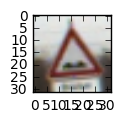

In [339]:
sources = [source]
repositories = [repository]

ds = Dataset(sources, repositories)
X_train, y_train,X_test, y_test = ds.deserialize()
print("Number of training examples =", ds.train_size)
print("Number of testing examples =", ds.test_size)
print("Image data shape =", ds.image_shape)
print("Number of classes =", ds.class_size)
#print("Number of label_per_class =", ds.label_per_class)
print("Max size of label_per_class =", ds.max_size_feature)
ds.visualize(X_train, y_train)
#args = (None,True)
# X_train, y_train = ds.balance(X_train,y_train,partial(apply_augmentation2),args)
#X_train, y_train =  apply_preprocessing(X_train, y_train,True) 
model = Model()
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
model.build(x,ds.class_size)
print('logits : ', model.logits)
trainer = Trainer(rate,EPOCHS,BATCH_SIZE,x,y,model.logits)
trainer.build_pipeline(ds.class_size)
trainer.train_model(X_train, y_train)
trainer.test_model(X_test, y_test)



